In [120]:
import pandas as pd
import numpy as np

from copy import deepcopy

from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

from gensim.models import KeyedVectors

GLOVE_PATH = "glove.6B/glove.6B.300d.txt"
GLOVE_W2V_FORMAT = "glove_w2v.txt"
FINAL_MODEL_PATH = "glove_final.txt"

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [121]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Preparing embeddings

In [7]:
# _ = glove2word2vec(GLOVE_PATH, GLOVE_W2V_FORMAT)

In [129]:
model = KeyedVectors.load_word2vec_format(GLOVE_W2V_FORMAT)

In [4]:
def clean_pos(model):
    """
    cleaning pos
    """
    new_vocab = {}
    for k in model.vocab.keys():
        new_vocab[k.split('_')[0]] = deepcopy(model.vocab[k])
    model.vocab = new_vocab
    model.index2word = [i.split('_')[0] for i in model.index2word]
    return model


In [7]:
clean_model = clean_pos(model)
clean_model.save(FINAL_MODEL_PATH)

In [83]:
class Vectorizer(object):

    def __init__(self, model):
        
        self.model = model
        self.dim = model.vector_size

    def transform(self, word):
      
        if word in self.model.vocab.keys():
            word_vec = self.model.word_vec(word)
                    
            return np.array(word_vec)
        
        else:
            return None

In [84]:
vectorizer = Vectorizer(clean_model)

In [86]:
vectorizer.transform('test').shape

(300,)

### Preparing data

In [20]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [33]:
emb_train = vectorizer.transform(train_df['text'])
emb_test = vectorizer.transform(test_df['text'])

/home/timmagg/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/timmagg/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [61]:
emb_train.shape

(3657,)

In [58]:
emb_train[0].shape

(300,)

### Classifying

In [63]:
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM, GlobalAveragePooling1D, SpatialDropout1D
from keras.datasets import imdb
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.layers import Flatten, GlobalMaxPool1D

from sklearn.utils import class_weight

In [39]:
def yes_no_int(text):
    if text == "Yes":
        return 1
    else:
        return 0

In [40]:
train_df['labels'] = train_df['labels'].apply(yes_no_int)
test_df['labels'] = test_df['labels'].apply(yes_no_int)

In [41]:
texts = list(train_df['text'])
texts.extend(test_df['text'])
len(texts)

4649

In [42]:
labels = list(train_df['labels'])
labels.extend(test_df['labels'])
len(labels)

4649

In [43]:
tokenizer = Tokenizer(num_words=6000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

In [44]:
tokenizer.fit_on_texts(texts)

In [90]:
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = vectorizer.transform(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [52]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 train_df['labels'].unique(),
                                                 train_df['labels'])
print(class_weights)

[0.94349845 1.06369983]


In [93]:
x_test = tokenizer.texts_to_sequences(test_df['text'].values)
x_test = pad_sequences(x_test, maxlen=216, truncating='post')
x_train = tokenizer.texts_to_sequences(train_df['text'].values)
x_train = pad_sequences(x_train, maxlen=216, truncating='post')

In [94]:
vocab_size = len(tokenizer.word_index)

In [110]:
model = Sequential()
model.add(Embedding(vocab_size, 300, 
                       weights=[embedding_matrix], 
                       input_length=x_train.shape[1], 
                       trainable=False))
model.add(GlobalMaxPool1D())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 216, 300)          2062800   
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 300)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               154112    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 513       
Total params: 2,217,425
Trainable params: 154,625
Non-trainable params: 2,062,800
_________________________________________________________________


In [111]:
checkpointer = ModelCheckpoint(filepath="weights_sol3.hdf5", verbose=1, save_best_only=True)

In [125]:
history = model.fit(x_train, train_df['labels'],
          class_weight=class_weights,
          batch_size=512,
          epochs=30,
          validation_data=(x_test, test_df['labels']),
          callbacks=[checkpointer])

Train on 3657 samples, validate on 992 samples
Epoch 1/30
3657/3657 [==============================] - 0s 108us/step - loss: 0.4851 - acc: 0.7566 - val_loss: 0.8125 - val_acc: 0.5343

Epoch 00001: val_loss did not improve from 0.45519
Epoch 2/30
3657/3657 [==============================] - 0s 103us/step - loss: 0.4846 - acc: 0.7616 - val_loss: 0.9093 - val_acc: 0.4738

Epoch 00002: val_loss did not improve from 0.45519
Epoch 3/30
3657/3657 [==============================] - 0s 114us/step - loss: 0.4818 - acc: 0.7566 - val_loss: 0.6684 - val_acc: 0.6169

Epoch 00003: val_loss did not improve from 0.45519
Epoch 4/30
3657/3657 [==============================] - 0s 118us/step - loss: 0.4417 - acc: 0.7935 - val_loss: 0.5385 - val_acc: 0.7208

Epoch 00004: val_loss did not improve from 0.45519
Epoch 5/30
3657/3657 [==============================] - 0s 112us/step - loss: 0.4304 - acc: 0.7952 - val_loss: 0.4635 - val_acc: 0.7833

Epoch 00005: val_loss did not improve from 0.45519
Epoch 6/30
36

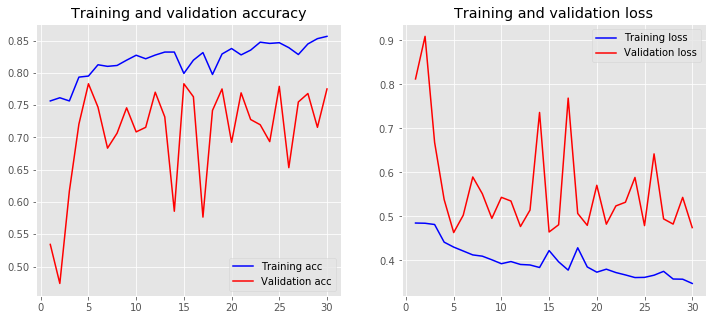

In [126]:
plot_history(history)

In [127]:
model.load_weights("weights_sol3.hdf5")

In [128]:
score, acc = model.evaluate(x_test, test_df['labels'], batch_size=512)
print('Test loss:', score)
print('Test accuracy:', acc)

992/992 [==============================] - 0s 100us/step
Test loss: 0.45519117001564274
Test accuracy: 0.7943548521687908
